

# Car Price Prediction


In [1]:
import warnings
warnings.filterwarnings('ignore')

#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.signal import savgol_filter
from statsmodels.sandbox.stats.runs import runstest_1samp
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

### Step 1: Reading and Understanding the cars



In [2]:
cars = pd.read_csv('car-data.csv')
cars.head()

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5


In [3]:
cars.shape

(15157, 8)

In [4]:
cars.isnull().sum()

year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [5]:
cars.describe()

,year,price,mileage,tax,mpg,engineSize
count,15157.000000,15157.000000,15157.000000,15157.000000,15157.000000,15157.000000
mean,2017.255789,16838.952365,22092.785644,112.744277,53.753355,1.600693
std,2.053059,7755.015206,21148.941635,63.482617,13.642182,0.461695
min,2000.000000,899.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10990.000000,5962.000000,30.000000,46.300000,1.200000
50%,2017.000000,15497.000000,16393.000000,145.000000,53.300000,1.600000
75%,2019.000000,20998.000000,31824.000000,145.000000,60.100000,2.000000
max,2020.000000,69994.000000,212000.000000,580.000000,188.300000,3.200000


In [6]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15157 entries, 0 to 15156
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          15157 non-null  int64  
 1   price         15157 non-null  int64  
 2   transmission  15157 non-null  object 
 3   mileage       15157 non-null  int64  
 4   fuelType      15157 non-null  object 
 5   tax           15157 non-null  int64  
 6   mpg           15157 non-null  float64
 7   engineSize    15157 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 947.4+ KB


### Step 2 : cars Cleaning and Preparation

In [7]:
#Checking for duplicates
cars.loc[cars.duplicated()]

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
40,2018,18695,Manual,6753,Petrol,145,53.3,1.5
45,2018,17995,Manual,14837,Petrol,145,53.3,1.5
46,2018,17995,Manual,14337,Petrol,145,53.3,1.5
48,2019,22230,Manual,3392,Diesel,145,50.4,2.0
61,2019,25990,Semi-Auto,2423,Diesel,145,49.6,2.0
...,...,...,...,...,...,...,...,...
14477,2019,19360,Semi-Auto,4401,Diesel,145,50.4,2.0
14495,2019,22798,Manual,10,Petrol,145,43.5,1.5
14498,2019,23998,Semi-Auto,10,Diesel,145,50.4,2.0
14499,2019,21998,Semi-Auto,10,Petrol,145,42.8,1.5


In [8]:
cars.columns

Index(['year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg',
       'engineSize'],
      dtype='object')

In [9]:
cars.transmission.value_counts()


Manual       9417
Semi-Auto    3780
Automatic    1960
Name: transmission, dtype: int64

In [10]:
cars_drop = cars.dropna()#this will give the non null values
cars_drop.shape

(15157, 8)

In [11]:
print(cars.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count    15157.000000
mean     16838.952365
std       7755.015206
min        899.000000
25%      10990.000000
50%      15497.000000
75%      20998.000000
85%      24485.600000
90%      26990.000000
100%     69994.000000
max      69994.000000
Name: price, dtype: float64


In [12]:
def detect_outliers(cars):
    outliers = []
    threshold = 3
    mean = np.mean(cars)
    std = np.std(cars)
    for i in cars :
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return (outliers)

In [13]:
print(detect_outliers(cars_drop['mpg']))
print(detect_outliers(cars_drop['tax']))
print(detect_outliers(cars_drop['price']))

[166.2, 166.2, 188.3, 166.2, 156.9, 166.2, 141.3, 141.3, 141.3, 156.9, 156.9, 141.3, 188.3, 156.9, 188.3, 188.3, 156.9, 188.3, 156.9, 156.9, 156.9, 156.9, 188.3, 156.9, 156.9, 166.2, 141.3, 166.2, 166.2, 156.9, 156.9, 156.9, 166.2, 156.9, 166.2, 141.3, 156.9, 188.3, 156.9, 156.9, 166.2, 156.9, 166.2, 156.9, 141.3, 166.2, 166.2, 166.2, 188.3, 156.9, 156.9, 141.3, 141.3, 156.9, 156.9, 188.3, 188.3, 188.3, 188.3, 188.3, 188.3, 156.9, 188.3, 188.3, 188.3, 166.2, 188.3, 166.2, 188.3, 166.2, 188.3, 188.3, 166.2, 166.2, 156.9, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 166.0, 0.3]
[325, 305, 570, 305, 305, 305, 325, 555, 330, 305, 305, 325, 325, 330, 325, 325, 325, 325, 325, 325, 315, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 570, 305, 580, 555, 570, 305, 325]
[40995, 40999, 41990, 43995, 47000, 40980, 40999, 42900, 52999, 40999, 46795, 43495, 43194, 47994, 50395, 42495, 4599

In [14]:
Q1 = cars_drop.quantile(0.25)
Q3 = cars_drop.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

year              3.0
price         10008.0
mileage       25862.0
tax             115.0
mpg              13.8
engineSize        0.8
dtype: float64


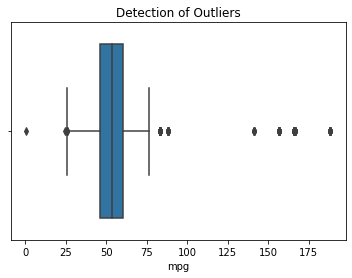

In [15]:
p = sns.boxplot(x= "mpg",data = cars_drop)
plt.xlabel('mpg')
plt.title('Detection of Outliers')
plt.show(block=False)

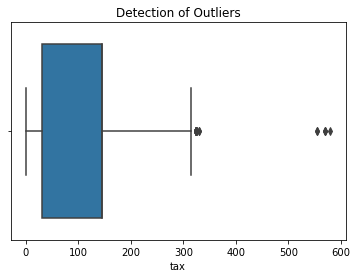

In [16]:
p = sns.boxplot(x= "tax",data= cars_drop)
plt.xlabel('tax')
plt.title('Detection of Outliers')
plt.show(p)

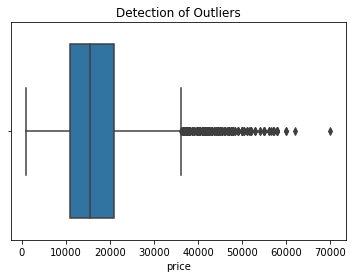

In [17]:
p = sns.boxplot(x= "price",data = cars_drop)
plt.xlabel('price')
plt.title('Detection of Outliers')
plt.show(p)

In [18]:
cars_output = cars_drop[~((cars_drop<(Q1-1.5*IQR)) | (cars_drop>(Q3+1.5*IQR))).any(axis=1)]
cars_output.head()


,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5


In [19]:
cars_output.shape

(14073, 8)

# LABEL ENCODING




### Step 3: Visualizing the cars


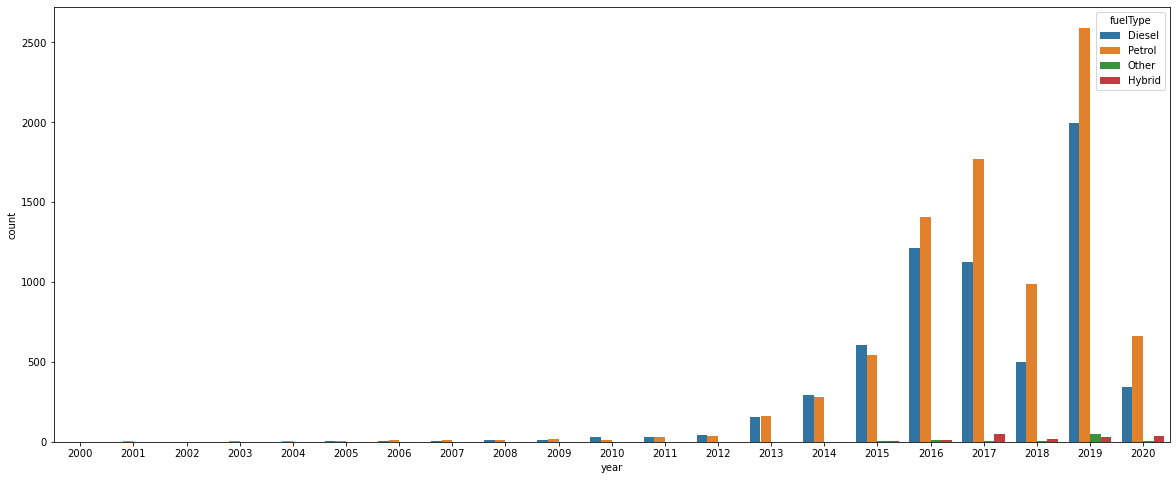

In [20]:
plt.figure(figsize=(20,8))

p = (sns.countplot(x='year',y=None,hue='fuelType',data=cars_drop,))
plt.show(p)

In [21]:
Petrol = cars_drop[cars_drop['fuelType']=='Petrol']
Diesel = cars_drop[cars_drop['fuelType']=='Diesel']
Other = cars_drop[cars_drop['fuelType']=='Other']
Hybrid = cars_drop[cars_drop['fuelType']=='Hybrid']

In [22]:
cars.fuelType.value_counts()

Petrol    8553
Diesel    6372
Hybrid     145
Other       87
Name: fuelType, dtype: int64

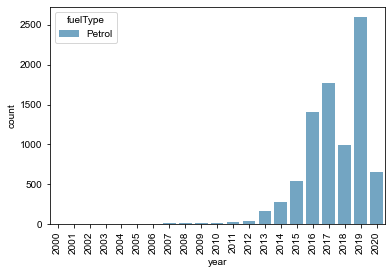

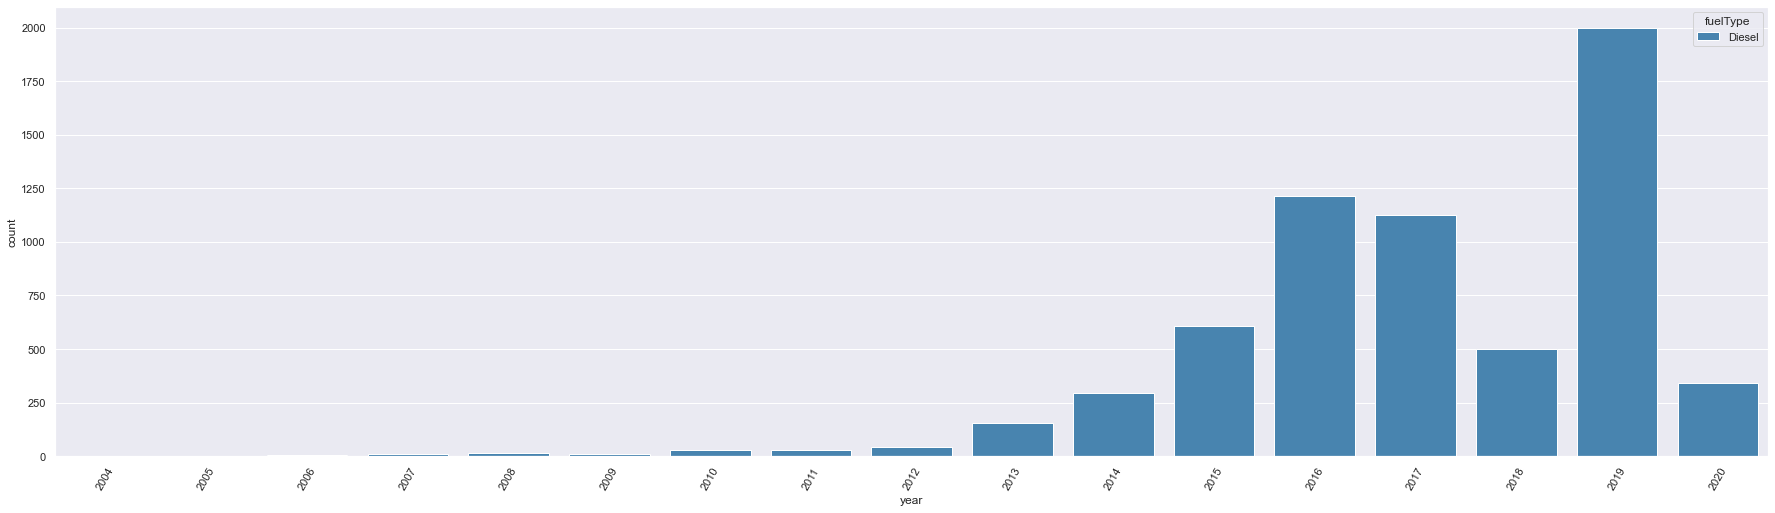

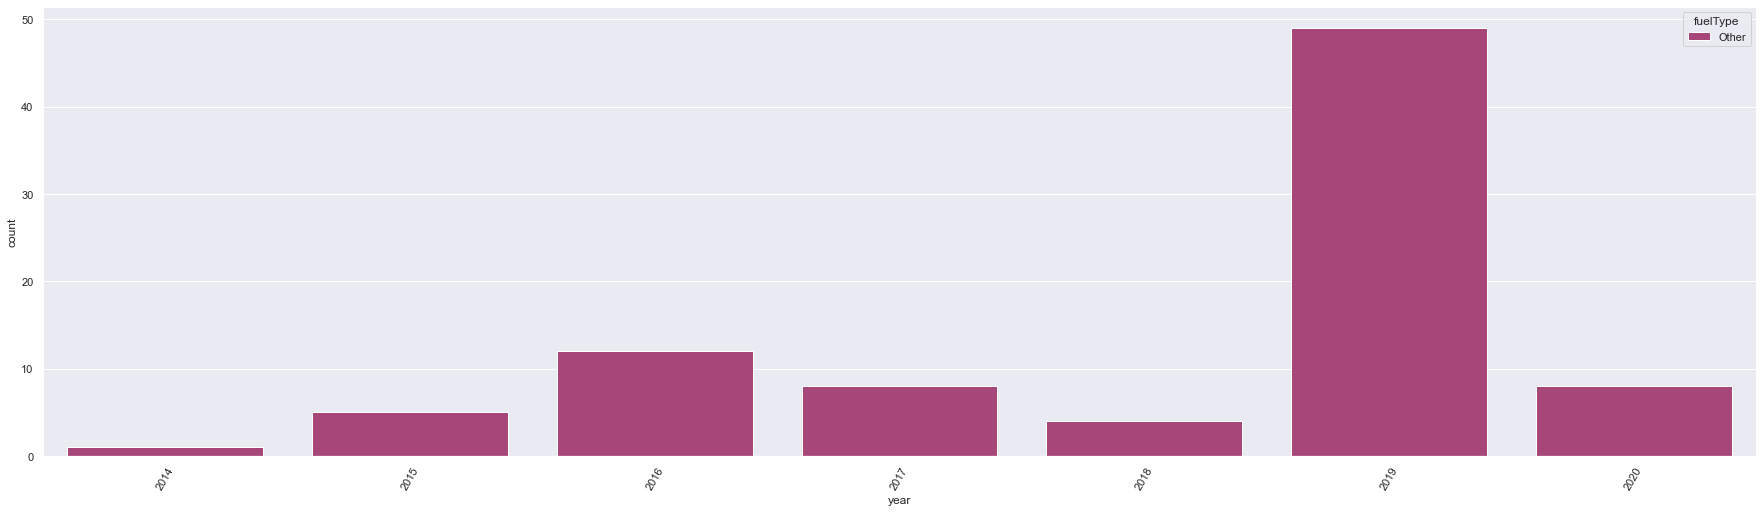

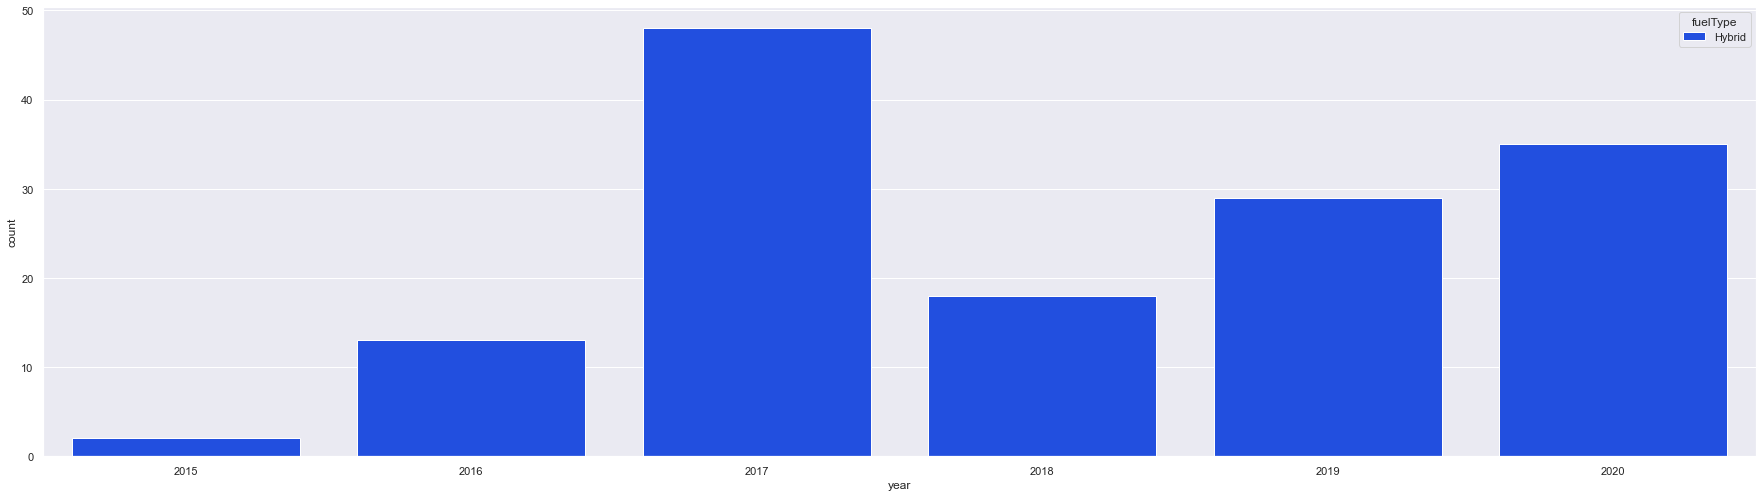

In [23]:
p = sns.countplot(x='year',y=None,hue='fuelType',data= Petrol,palette=("PuBuGn"))
sns.set(rc={'figure.figsize':(30.7,8.27)})
plt.setp(p.get_xticklabels(), rotation=90)
plt.show(p)


p = sns.countplot(x='year',y=None,hue='fuelType',data= Diesel,palette=("Blues_d"))
sns.set(rc={'figure.figsize':(30.7,8.27)})
plt.setp(p.get_xticklabels(), rotation=60)
plt.show(p)

p = sns.countplot(x='year',y=None,hue='fuelType',data= Other,palette=("magma"))
sns.set(rc={'figure.figsize':(30.7,8.27)})
plt.setp(p.get_xticklabels(), rotation=60)
plt.show(p)

r = sns.countplot(x='year',y=None,hue='fuelType',data= Hybrid,palette=("bright"))
sns.set(rc={'figure.figsize':(30.7,8.27)})
plt.setp(p.get_xticklabels(), rotation=60)
plt.show(r)

<AxesSubplot:>

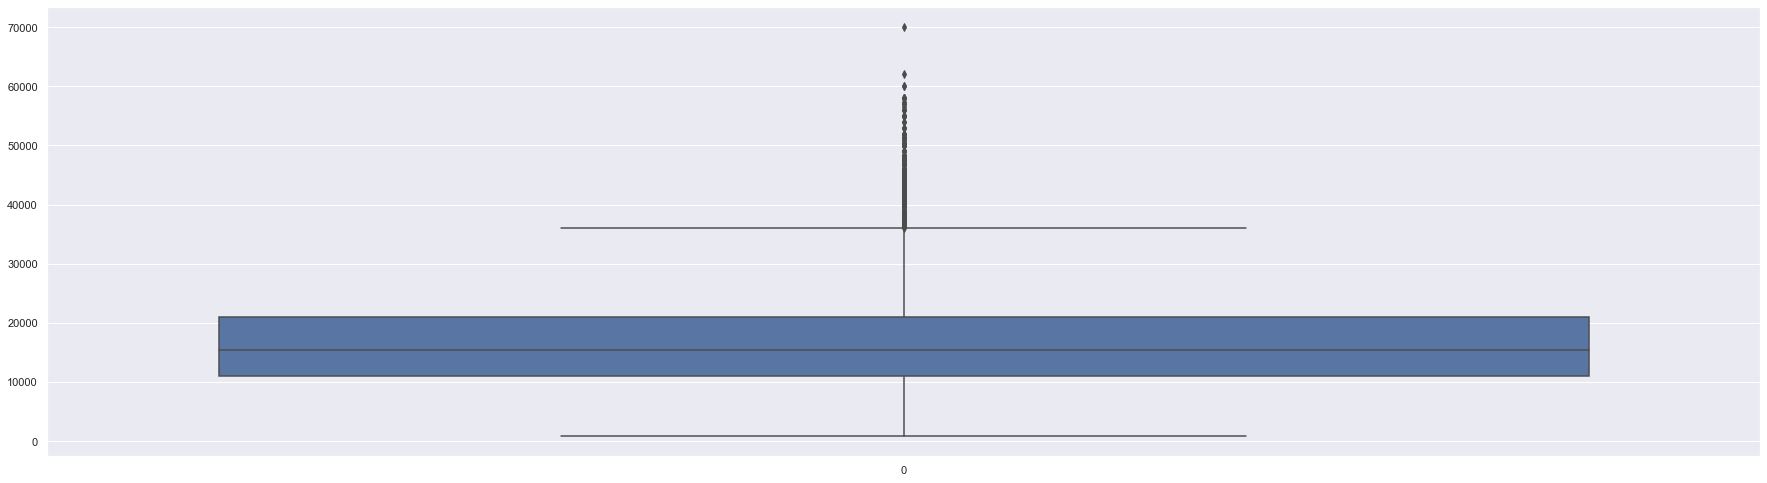

In [24]:
sns.boxplot(data=cars.price)

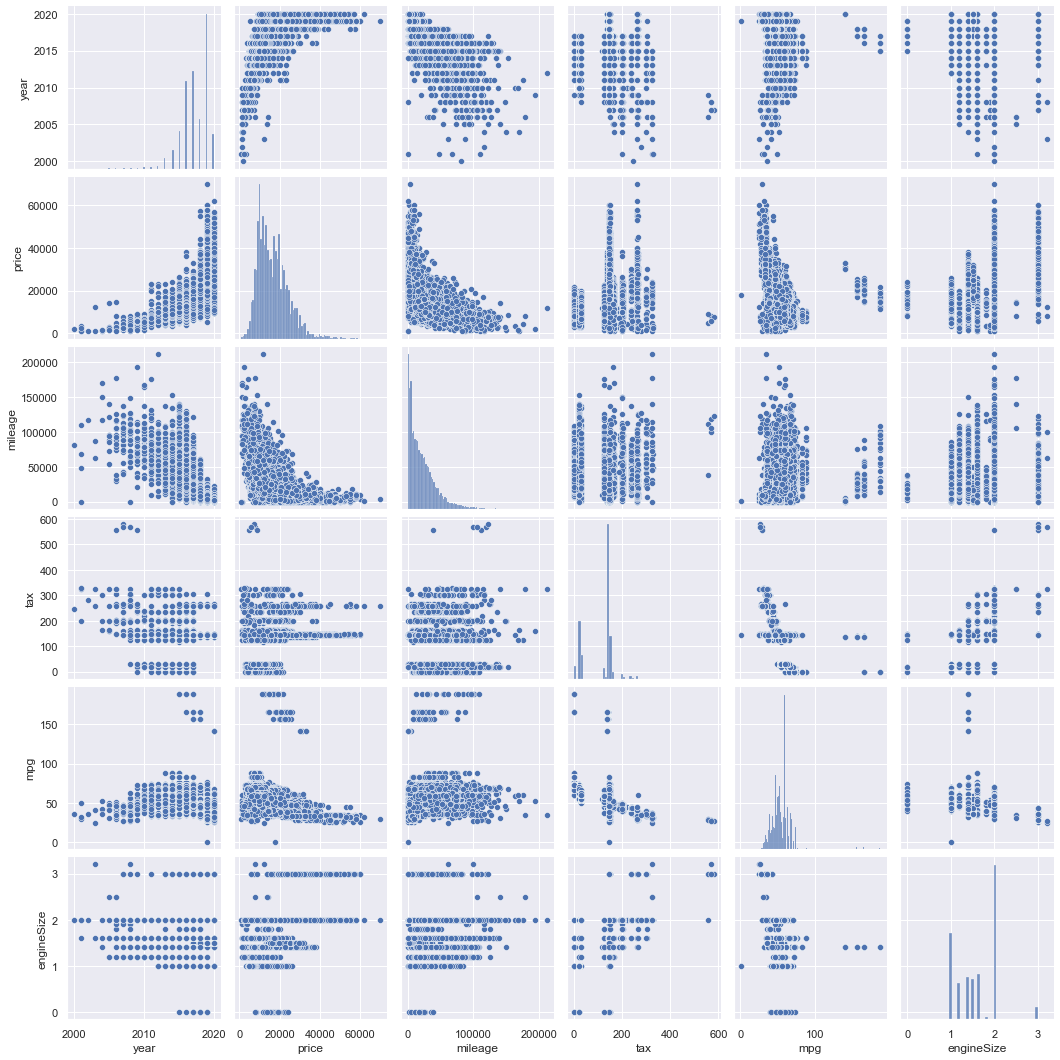

In [25]:
sns.pairplot(data = cars_drop)

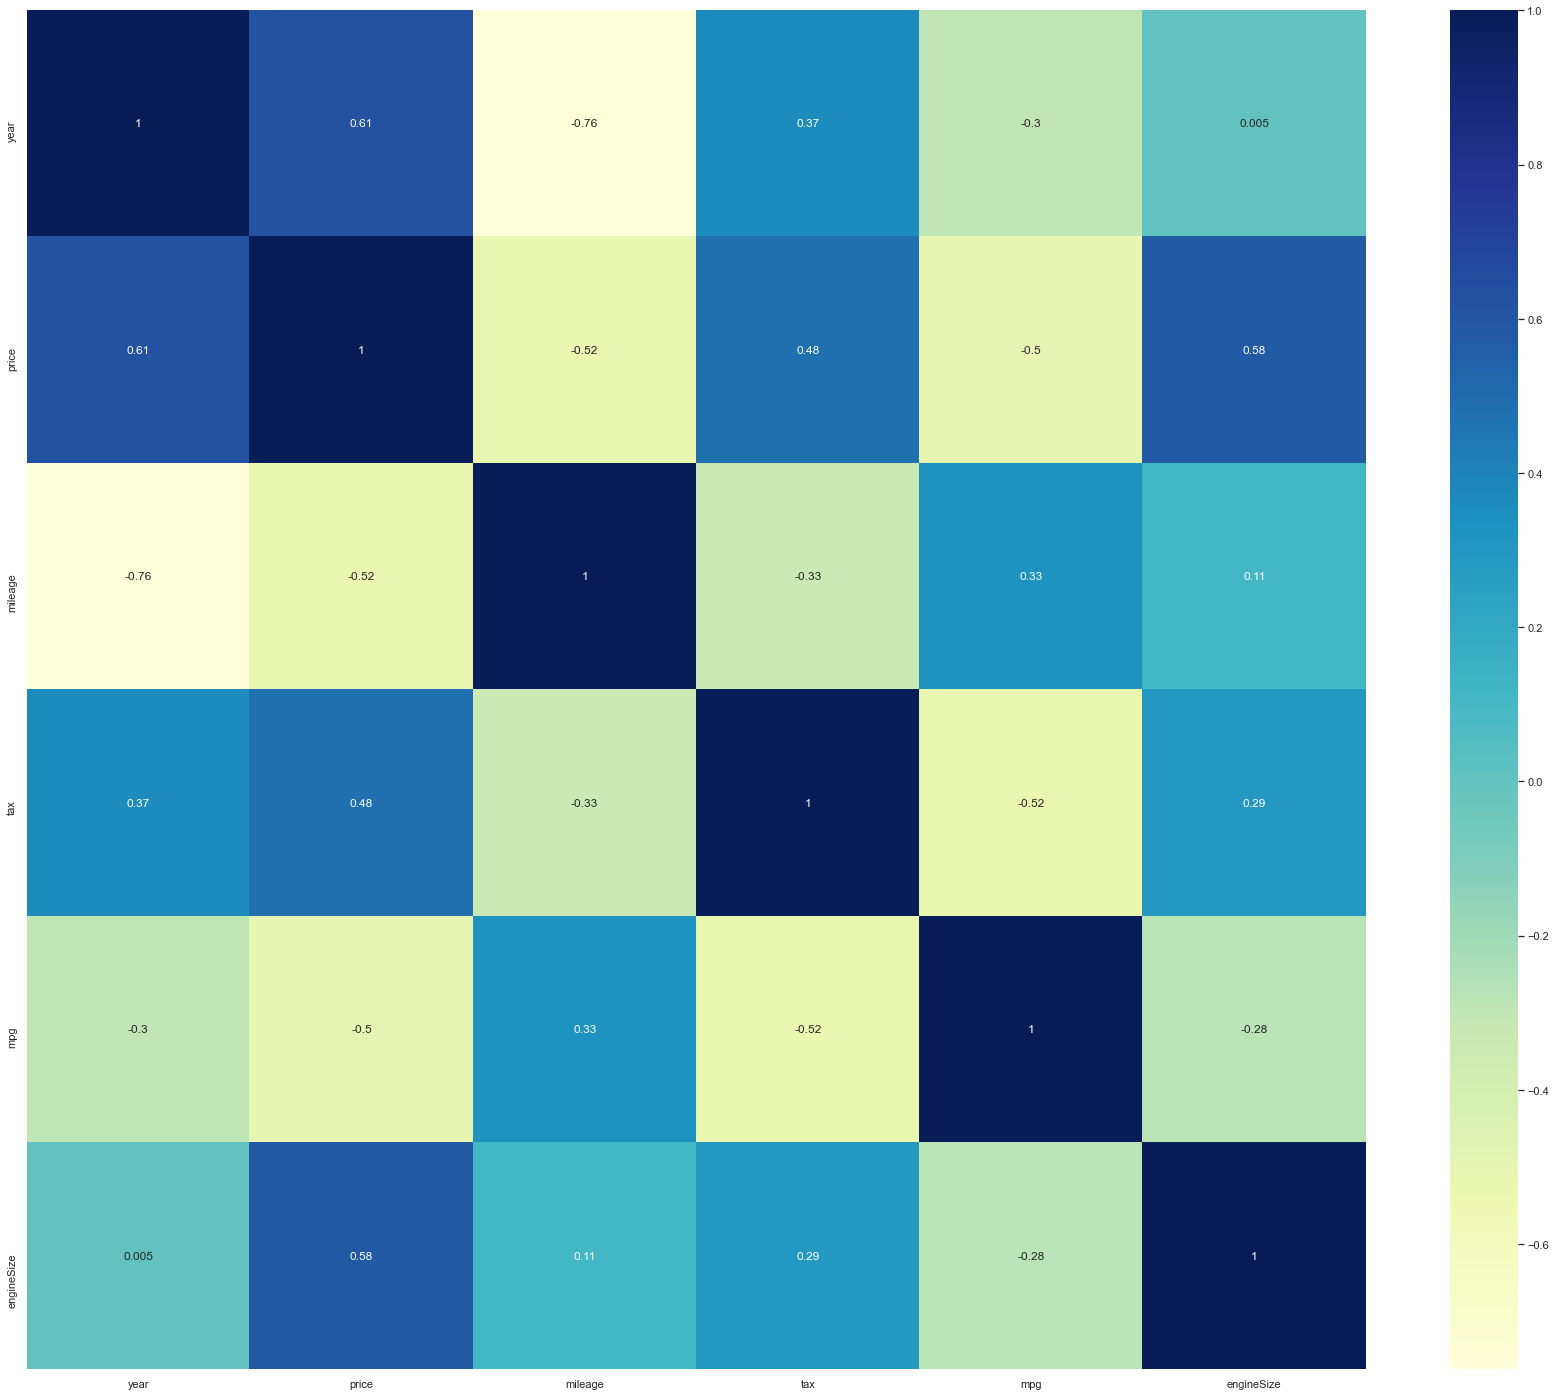

In [26]:
#Correlation using heatmap
plt.figure(figsize = (30, 25))
sns.heatmap(cars.corr(), annot = True, cmap="YlGnBu")
plt.show()

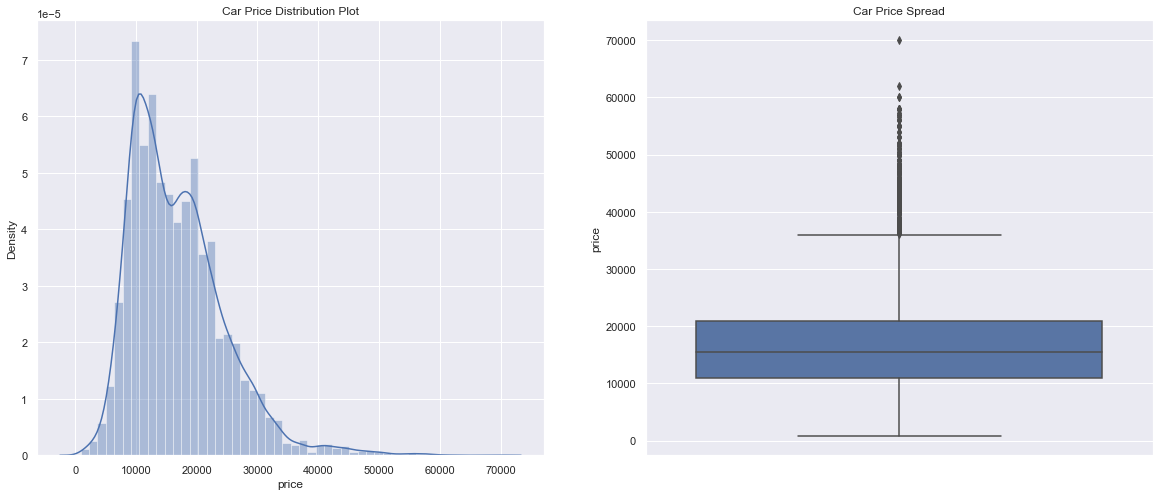

In [27]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(cars.price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=cars.price)

plt.show()

In [28]:
print(cars.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count    15157.000000
mean     16838.952365
std       7755.015206
min        899.000000
25%      10990.000000
50%      15497.000000
75%      20998.000000
85%      24485.600000
90%      26990.000000
100%     69994.000000
max      69994.000000
Name: price, dtype: float64


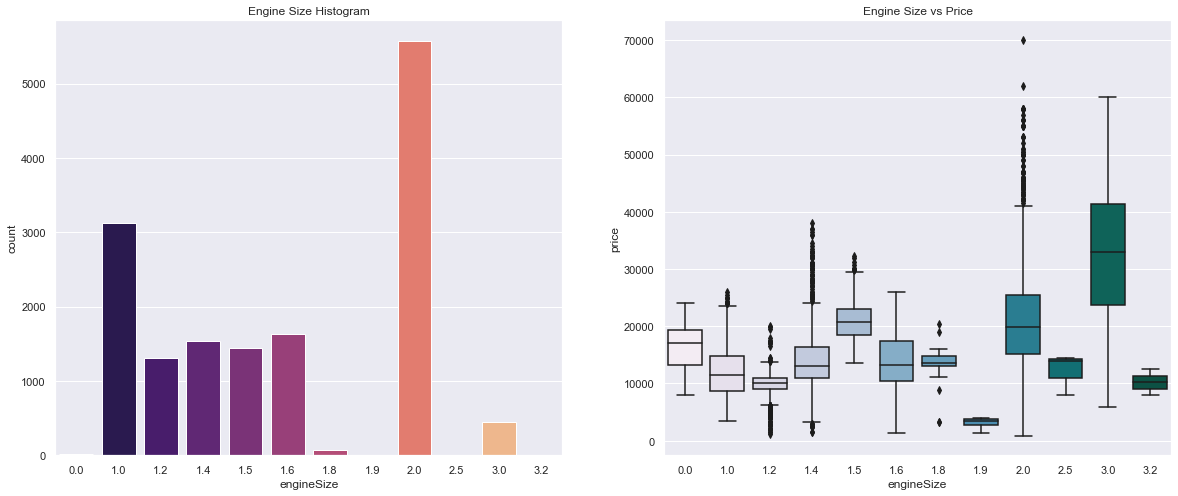

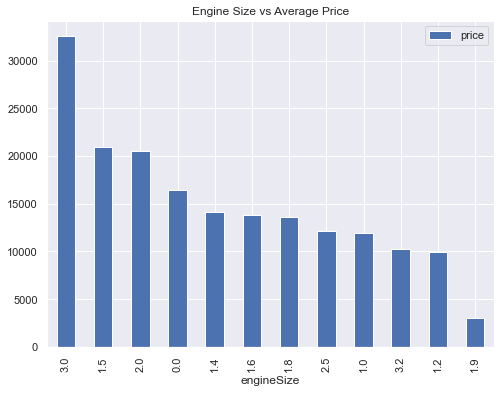

In [29]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Engine Size Histogram')
sns.countplot(cars.engineSize, palette=("magma"))

plt.subplot(1,2,2)
plt.title('Engine Size vs Price')
sns.boxplot(x=cars.engineSize, y=cars.price, palette=("PuBuGn"))

plt.show()

df = pd.DataFrame(cars.groupby(['engineSize'])['price'].mean().sort_values(ascending = False))
df.plot.bar(figsize=(8,6))
plt.title('Engine Size vs Average Price')
plt.show()


<Figure size 1800x432 with 0 Axes>

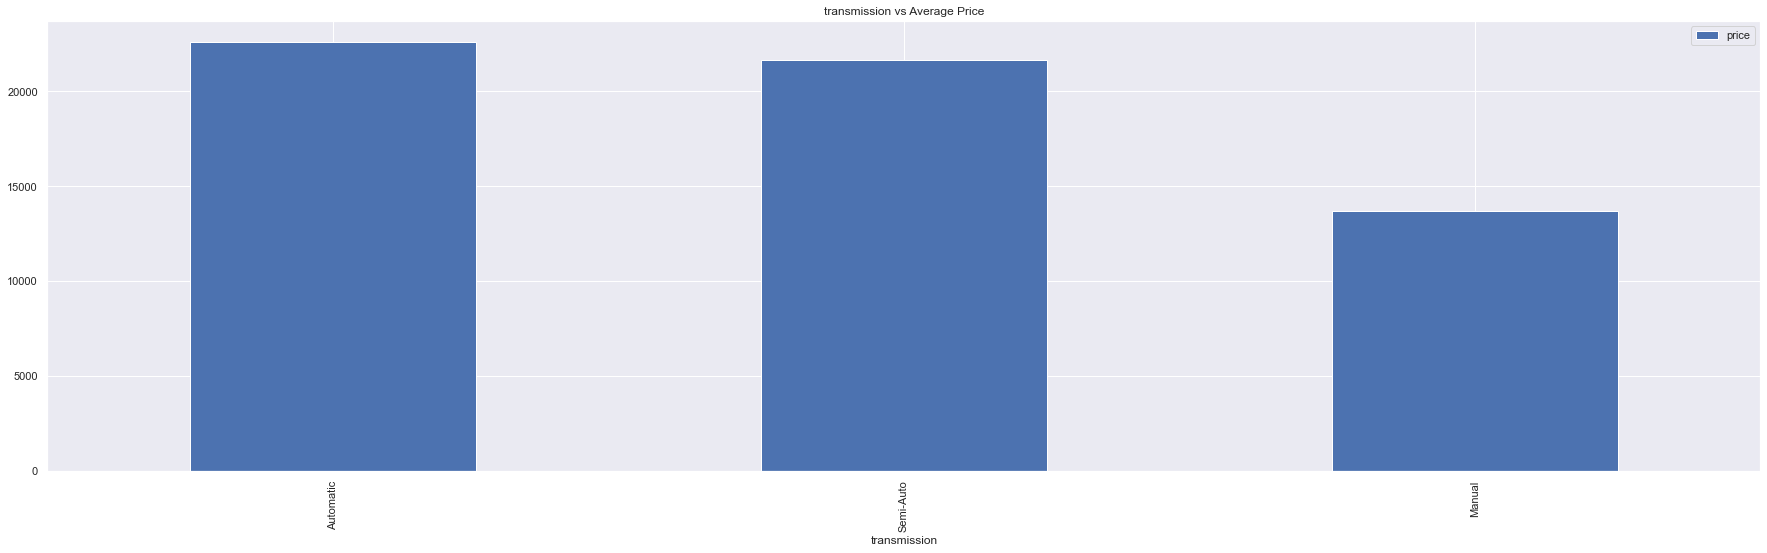

In [30]:
plt.figure(figsize=(25, 6))

df = pd.DataFrame(cars.groupby(['transmission'])['price'].mean().sort_values(ascending = False))
df.plot.bar()
plt.title('transmission vs Average Price')
plt.show()




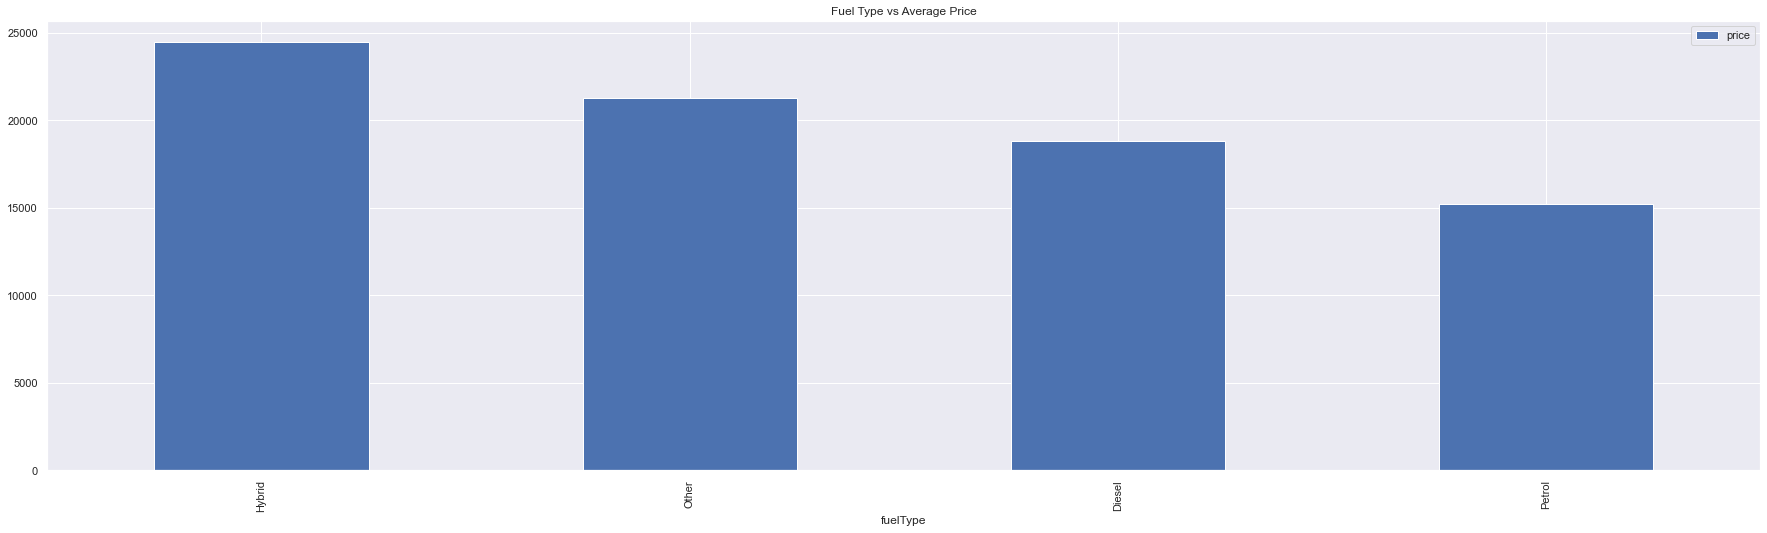

In [31]:
df = pd.DataFrame(cars.groupby(['fuelType'])['price'].mean().sort_values(ascending = False))
df.plot.bar()
plt.title('Fuel Type vs Average Price')
plt.show()

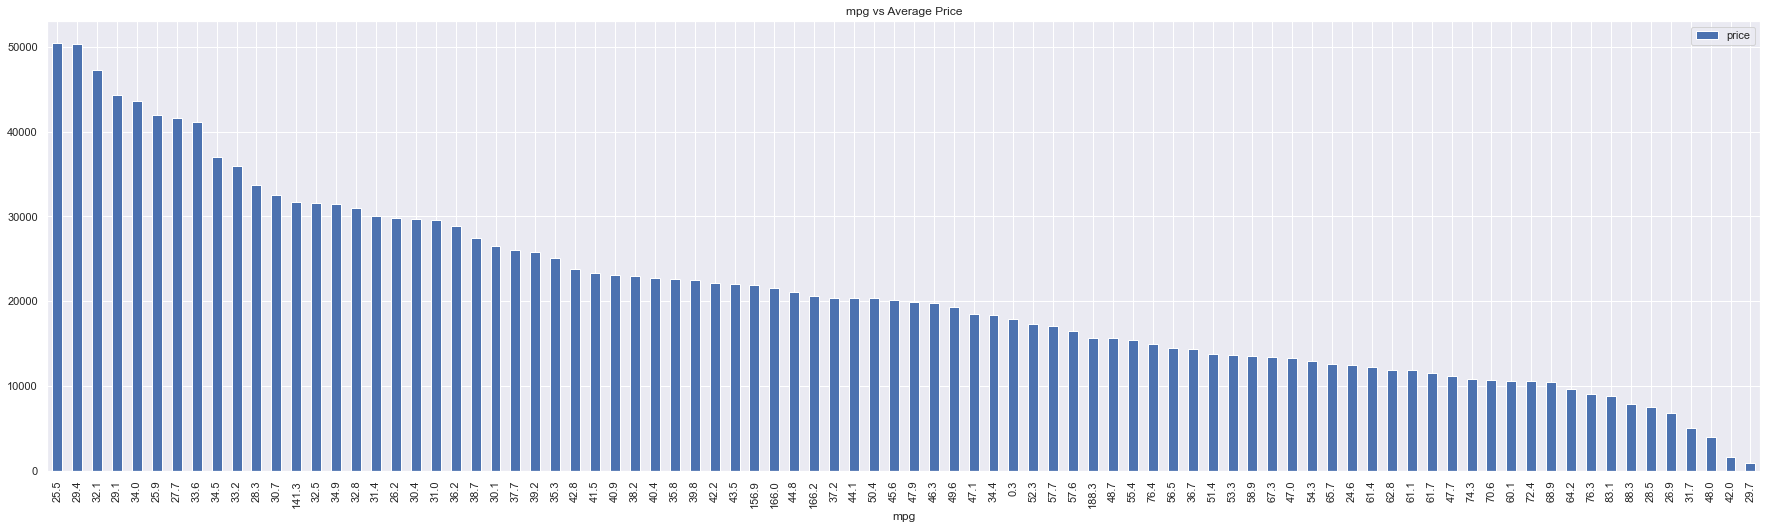

In [32]:
df = pd.DataFrame(cars.groupby(['mpg'])['price'].mean().sort_values(ascending = False))
df.plot.bar()
plt.title('mpg vs Average Price')
plt.show()

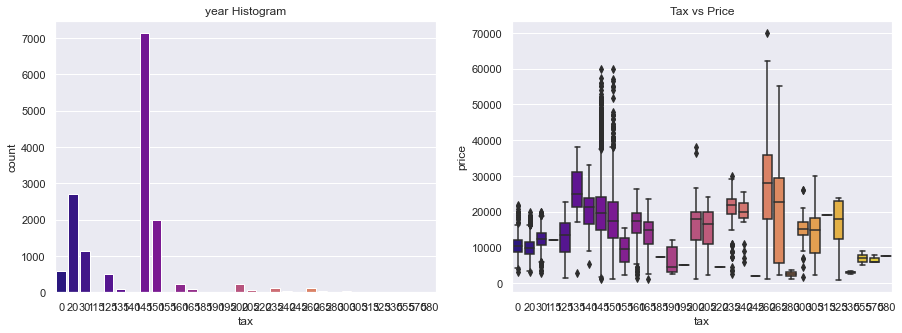

In [33]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('year Histogram')
sns.countplot(cars.tax, palette=("plasma"))

plt.subplot(1,2,2)
plt.title('Tax vs Price')
sns.boxplot(x=cars.tax, y=cars.price, palette=("plasma"))

plt.show()


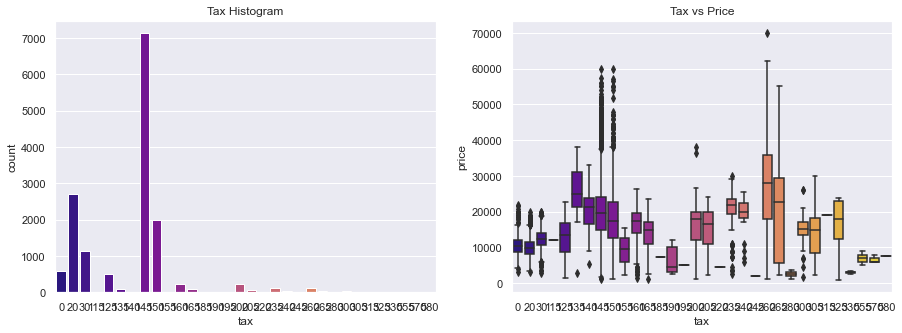

In [34]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Tax Histogram')
sns.countplot(cars.tax, palette=("plasma"))

plt.subplot(1,2,2)
plt.title('Tax vs Price')
sns.boxplot(x=cars.tax, y=cars.price, palette=("plasma"))

plt.show()


# Create Dummy Variables

In [35]:
cars_encode_dummy = pd.get_dummies(cars,columns=[ 'transmission','fuelType'], drop_first = True)
cars_encode_dummy

,year,price,mileage,tax,mpg,engineSize,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2019,25000,13904,145,49.6,2.0,0,0,0,0,0
1,2019,26883,4562,145,49.6,2.0,0,0,0,0,0
2,2019,20000,7414,145,50.4,2.0,1,0,0,0,0
3,2019,33492,4825,145,32.5,2.0,0,0,0,0,1
4,2019,22900,6500,150,39.8,1.5,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
15152,2012,5990,74000,125,58.9,2.0,1,0,0,0,0
15153,2008,1799,88102,145,46.3,1.2,1,0,0,0,1
15154,2009,1590,70000,200,42.0,1.4,1,0,0,0,1
15155,2006,1250,82704,150,46.3,1.2,1,0,0,0,1


In [36]:
transmission_unique = cars['transmission'].unique()
fueltype_unique = cars['fuelType'].unique()

transmission_unique.sort()
fueltype_unique.sort()

print(cars_encode_dummy.columns)
print(transmission_unique)
print(fueltype_unique)

Index(['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize',
       'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Hybrid',
       'fuelType_Other', 'fuelType_Petrol'],
      dtype='object')
['Automatic' 'Manual' 'Semi-Auto']
['Diesel' 'Hybrid' 'Other' 'Petrol']


# Asumptions Check

##  Linearity

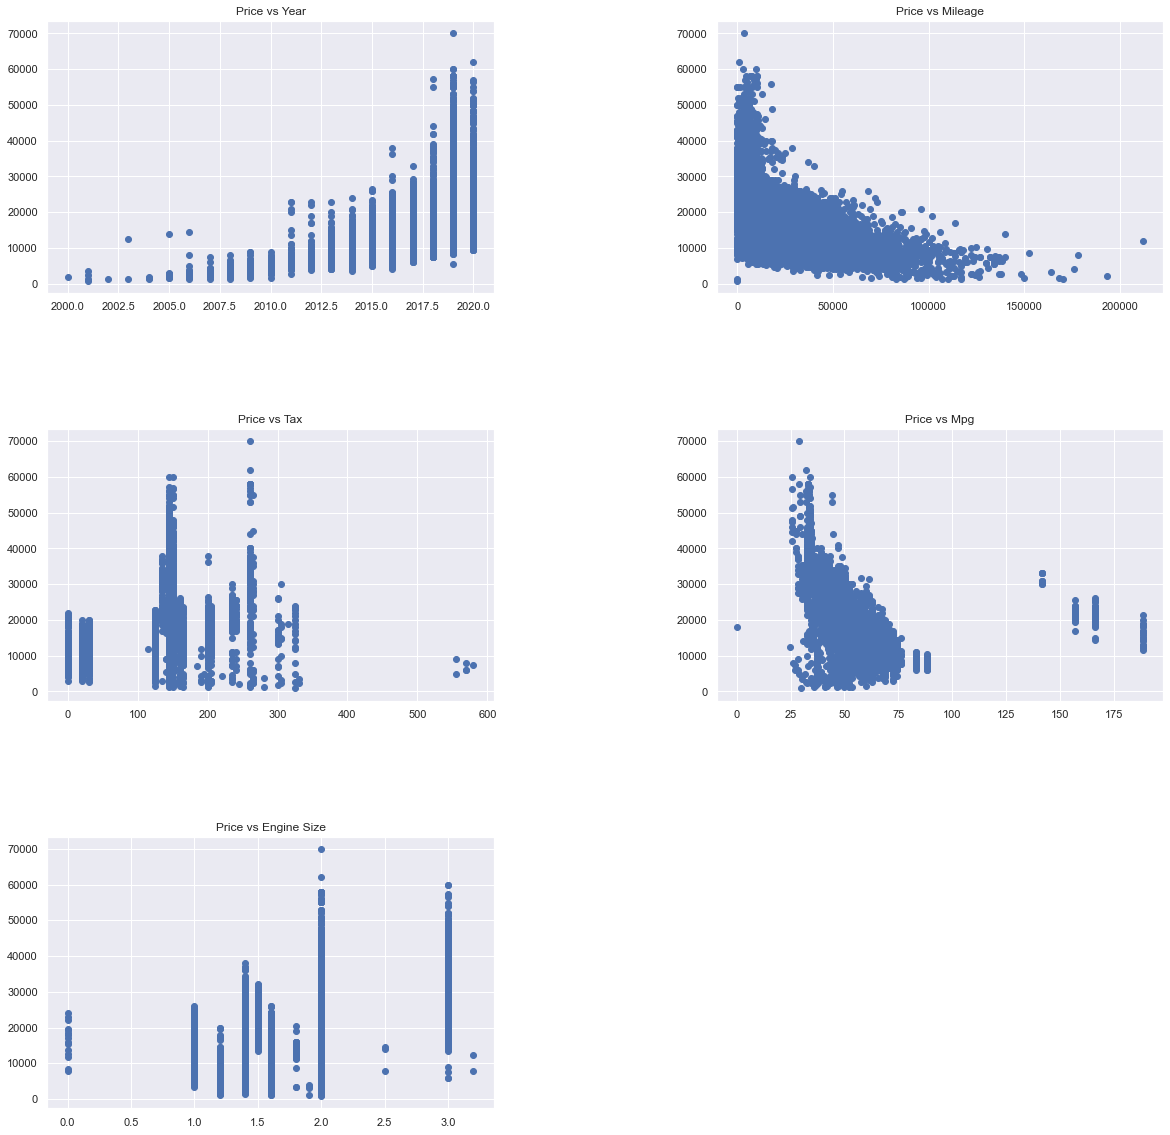

In [37]:
X = cars_encode_dummy.drop(columns = ['price'])
Y = cars_encode_dummy['price']

title = ['Price vs Year', 
         'Price vs Mileage', 
         'Price vs Tax', 
         'Price vs Mpg', 
         'Price vs Engine Size']

fig,ax = plt.subplots(3,2,figsize=(20,20))

i = 0
for rows in range(3):
    for cols in range(2):
        if rows == 2 and cols == 1:
            fig.delaxes(ax[rows,cols])
            break
        ax[rows,cols].scatter(x = X[X.columns[i]], y = Y)
        ax[rows,cols].set_title(title[i])
        i = i+1
        
fig.subplots_adjust(hspace=0.5, wspace=0.5)

We can see from the plots above that not all of the independent variables has a linear relationship with the dependent variable ('price' is the dependent variable and the rest are the independent variables). Therefore, we need to transform the cars. Most of them have an exponentially relationship so we will only take the logarithm of the 'price' variable.

## Transformation

In [38]:
cars_encode_dummy_transform = cars_encode_dummy.copy()
cars_encode_dummy_transform['price'] = np.log(cars_encode_dummy_transform['price'])
cars_encode_dummy_transform

,year,price,mileage,tax,mpg,engineSize,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2019,10.126631,13904,145,49.6,2.0,0,0,0,0,0
1,2019,10.199249,4562,145,49.6,2.0,0,0,0,0,0
2,2019,9.903488,7414,145,50.4,2.0,1,0,0,0,0
3,2019,10.419062,4825,145,32.5,2.0,0,0,0,0,1
4,2019,10.038892,6500,150,39.8,1.5,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
15152,2012,8.697847,74000,125,58.9,2.0,1,0,0,0,0
15153,2008,7.494986,88102,145,46.3,1.2,1,0,0,0,1
15154,2009,7.371489,70000,200,42.0,1.4,1,0,0,0,1
15155,2006,7.130899,82704,150,46.3,1.2,1,0,0,0,1


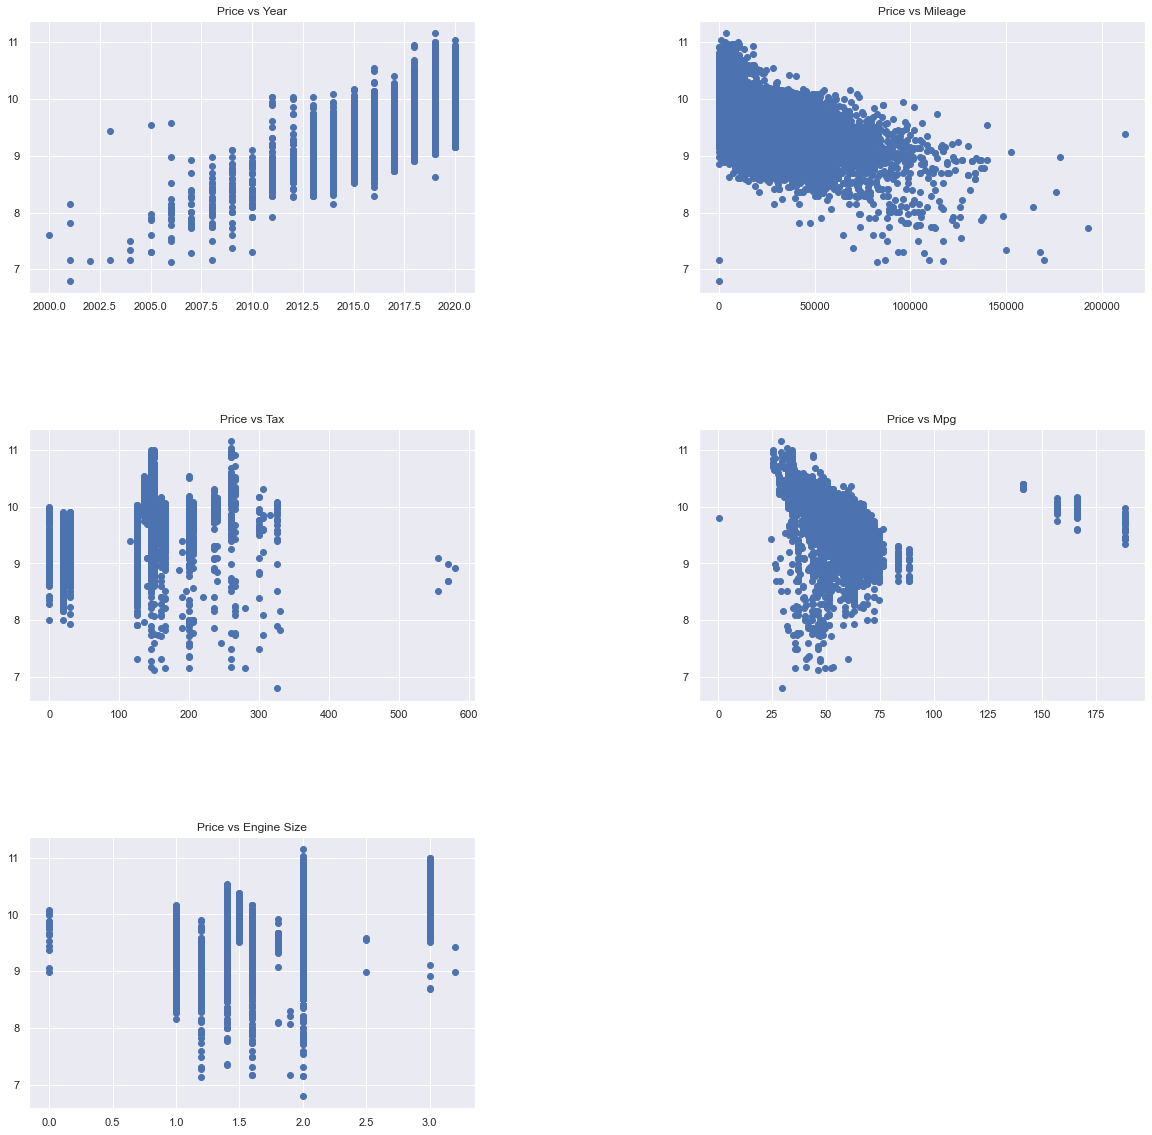

In [39]:
X = cars_encode_dummy_transform.drop(columns = ['price'])
Y = cars_encode_dummy_transform['price']

title = ['Price vs Year', 
         'Price vs Mileage', 
         'Price vs Tax', 
         'Price vs Mpg', 
         'Price vs Engine Size']

fig,ax = plt.subplots(3,2,figsize=(20,20))

i = 0
for rows in range(3):
    for cols in range(2):
        if rows == 2 and cols == 1:
            fig.delaxes(ax[rows,cols])
            break
        ax[rows,cols].scatter(x = X[X.columns[i]], y = Y)
        ax[rows,cols].set_title(title[i])
        i = i+1
        
fig.subplots_adjust(hspace=0.5, wspace=0.5)

After we transform it, we plot it again to check whether it's already linear or not. We can see that it's already linear so we can continue to the next step.

Note: I'm sorry for the long variables name. I just want to make it clear what those variables are hehe...

## Multicollinearity

In [40]:
X = cars_encode_dummy_transform[['year','mileage','tax','mpg','engineSize']]
X.corr()

,year,mileage,tax,mpg,engineSize
year,1.000000,-0.762574,0.365796,-0.297173,0.004957
mileage,-0.762574,1.000000,-0.330231,0.328949,0.110513
tax,0.365796,-0.330231,1.000000,-0.518440,0.291077
mpg,-0.297173,0.328949,-0.518440,1.000000,-0.277009
engineSize,0.004957,0.110513,0.291077,-0.277009,1.000000


We can see that the correlation between 'mileage' and 'year' is so high. Not only them, but also 'mpg' and 'tax'. We need to check the VIF to see the overall correlation between the independent variables.

In [41]:
VIF = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
                index=X.columns)
print(VIF)

year          52.713648
mileage        2.629886
tax            6.258503
mpg           24.569800
engineSize    15.699849
dtype: float64


We can see that the VIF for 'year', 'mpg', and 'engineSize' are more than 10. It means that those variables correlate with the other variables (for example, 'year' variable effects the values of all of the other independent variables). So there is a multicollinearity in this cars. From the statistics view, we can exclude the variables, but I don't know whether those variables are important to predict the price or not. So, I'll keep those variables.

# feature enginering


In [42]:
cars_onehot = pd.get_dummies(cars,columns=[ 'transmission','fuelType'])

In [43]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

Skewness: 1.1773646370342996
Kurtosis: 2.395538868195682


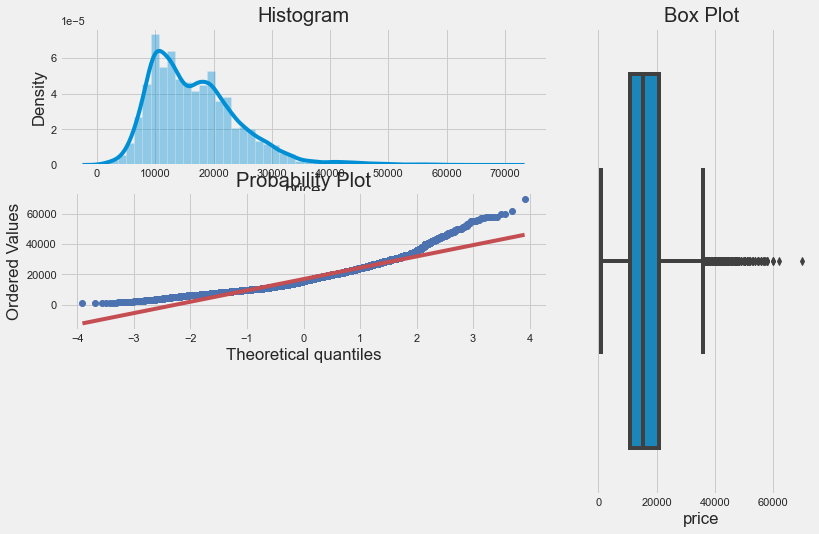

In [44]:
plotting_3_chart(cars_onehot, 'price')
#skewness and kurtosis
print("Skewness: " + str(cars_onehot['price'].skew()))
print("Kurtosis: " + str(cars_onehot['price'].kurt()))

In [45]:
from sklearn.model_selection import train_test_split
X = cars_onehot.drop(['price'],axis=1)
y = cars_onehot['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=25)

In [46]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
regressor.score(X,y)

0.8076023084212104

In [47]:
results = X_test.copy()
results["predicted"] = regressor.predict(X_test)
results["actual"]= y_test
results = results[['predicted', 'actual']]
results['predicted'] = results['predicted'].round(2)
results

,predicted,actual
3053,17892.63,12500
3542,15345.95,18000
5697,13548.18,10998
4092,40418.07,22495
1068,12857.40,15498
...,...,...
3426,14583.51,12926
1368,27641.18,26991
3926,22136.38,20990
11171,18735.87,14290


## binary encoding


In [48]:
# binary encoding

import category_encoders as ce
cars_bin = cars.copy()
encoder = ce.BinaryEncoder(cols=['transmission','fuelType'])
cars_bin = encoder.fit_transform(cars_bin)
cars_bin

,year,price,transmission_0,transmission_1,transmission_2,mileage,fuelType_0,fuelType_1,fuelType_2,tax,mpg,engineSize
0,2019,25000,0,0,1,13904,0,0,1,145,49.6,2.0
1,2019,26883,0,0,1,4562,0,0,1,145,49.6,2.0
2,2019,20000,0,1,0,7414,0,0,1,145,50.4,2.0
3,2019,33492,0,0,1,4825,0,1,0,145,32.5,2.0
4,2019,22900,0,1,1,6500,0,1,0,150,39.8,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...
15152,2012,5990,0,1,0,74000,0,0,1,125,58.9,2.0
15153,2008,1799,0,1,0,88102,0,1,0,145,46.3,1.2
15154,2009,1590,0,1,0,70000,0,1,0,200,42.0,1.4
15155,2006,1250,0,1,0,82704,0,1,0,150,46.3,1.2


Skewness: 1.1773646370342996
Kurtosis: 2.395538868195682


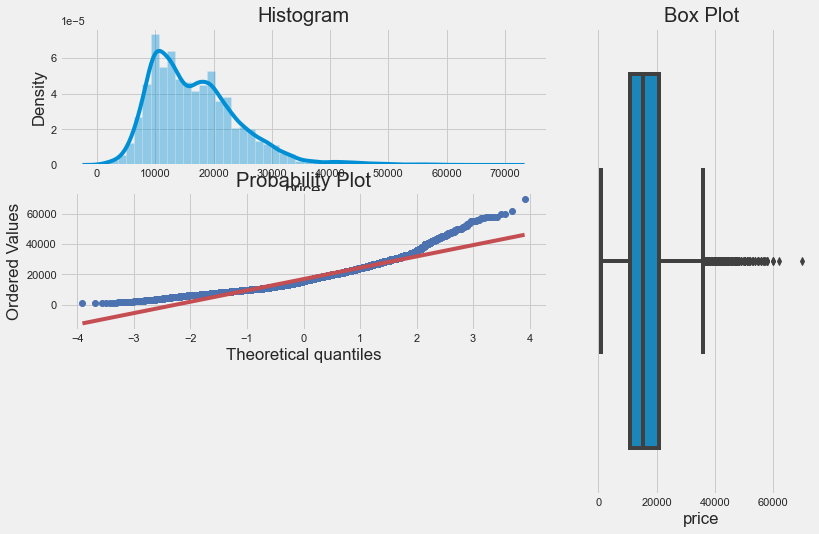

In [49]:
plotting_3_chart(cars_bin, 'price')
#skewness and kurtosis
print("Skewness: " + str(cars_bin['price'].skew()))
print("Kurtosis: " + str(cars_bin['price'].kurt()))

In [50]:
from sklearn.model_selection import train_test_split
X = cars_bin.drop(['price'],axis=1)
y = cars_bin['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=25)

In [51]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
regressor.score(X,y)

0.8076023084212104

In [52]:
results = X_test.copy()
results["predicted"] = regressor.predict(X_test)
results["actual"]= y_test
results = results[['predicted', 'actual']]
results['predicted'] = results['predicted'].round(2)
results

,predicted,actual
3053,17892.63,12500
3542,15345.95,18000
5697,13548.18,10998
4092,40418.07,22495
1068,12857.40,15498
...,...,...
3426,14583.51,12926
1368,27641.18,26991
3926,22136.38,20990
11171,18735.87,14290


Skewness: -0.34571961635063336
Kurtosis: 0.7947672317717793


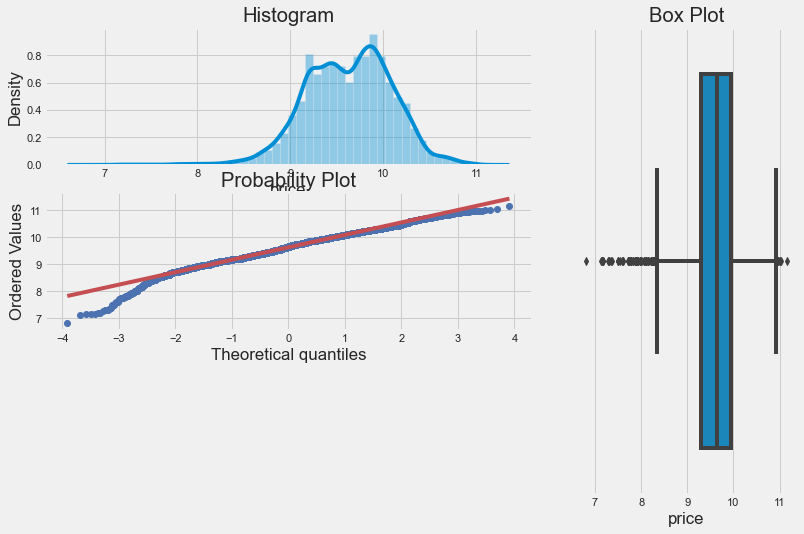

In [53]:
## trainsforming target variable using numpy.log1p,
log_cars = cars_onehot.copy()
log_cars["price"] = np.log1p(log_cars["price"])

## Plotting the newly transformed response variable
plotting_3_chart(log_cars, 'price')
#skewness and kurtosis
print("Skewness: " + str(log_cars['price'].skew()))
print("Kurtosis: " + str(log_cars['price'].kurt()))

In [54]:
(log_cars.corr()**2)["price"].sort_values(ascending = False)[1:]

year                      0.509807
mileage                   0.346273
engineSize                0.288993
transmission_Manual       0.248835
tax                       0.246065
mpg                       0.203705
transmission_Semi-Auto    0.130663
transmission_Automatic    0.065036
fuelType_Petrol           0.055911
fuelType_Diesel           0.044959
fuelType_Hybrid           0.008873
fuelType_Other            0.002039
Name: price, dtype: float64

In [55]:
from sklearn.model_selection import train_test_split
X = log_cars.drop(['price'],axis=1)
y = log_cars['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=25)

In [56]:
# Much improved score after adjusting distribution

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
print('Accuracy on Testing set: %.1f ' %(regressor.score(X_train,y_train)*100))

Accuracy on Testing set: 86.0 


In [57]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
pipeline_svr=Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=2)),
                     ('lr_classifier',SVR(kernel='linear'))])
pipeline_svr.fit(X_train, y_train)
pipeline_svr.score(X_test,y_test)


0.68499889294437

In [58]:
from sklearn.linear_model import Ridge,ElasticNet
ridge=Ridge(alpha=2,max_iter=1000,random_state=1)
ridge.fit(X_train,y_train)
print('Accuracy on Testing set: %.1f ' %(ridge.score(X_test,y_test)*100))

Accuracy on Testing set: 85.5 


In [59]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=1)
rf_reg.fit(X_train, y_train)
print('Accuracy on Testing set: %.1f ' %(rf_reg.score(X_test,y_test)*100))

Accuracy on Testing set: 94.5 


In [60]:
from sklearn.ensemble import GradientBoostingRegressor
GB=GradientBoostingRegressor(random_state=0)
GB.fit(X_test,y_test)
print('Performance Score(GB): %.1f ' %(GB.score(X_test,y_test)*100))

Performance Score(GB): 93.3 


In [61]:
from xgboost import XGBRegressor
XGB=XGBRegressor(random_state=0)
XGB.fit(X_train,y_train)
print('Performance score(XGB): %.1f ' %(XGB.score(X_test,y_test)*100))

Performance score(XGB): 94.8 


In [72]:
XGB

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [63]:
results = X_test.copy()
results["predicted"] = np.expm1(XGB.predict(X_test))
results["actual"]= np.expm1(y_test)
results = results[['predicted', 'actual']]
results['predicted'] = results['predicted'].round(2)
results

,predicted,actual
3053,13846.219727,12500.0
3542,16574.550781,18000.0
5697,11055.669922,10998.0
4092,25287.169922,22495.0
1068,14177.209961,15498.0
...,...,...
3426,14119.269531,12926.0
1368,29851.669922,26991.0
3926,21634.220703,20990.0
11171,17190.009766,14290.0


In [76]:
results

,predicted,actual
3053,13846.219727,12500.0
3542,16574.550781,18000.0
5697,11055.669922,10998.0
4092,25287.169922,22495.0
1068,14177.209961,15498.0
...,...,...
3426,14119.269531,12926.0
1368,29851.669922,26991.0
3926,21634.220703,20990.0
11171,17190.009766,14290.0
